<a href="https://colab.research.google.com/github/ShikhaERAV2/ERAV2Session5/blob/main/ERAV2_Assignment5_Shikha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CODE BLOCK: 1

In [89]:
# import the necessary packages.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision import datasets, transforms

CODE BLOCK: 2

In [90]:
# Load CUDa
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

CUDA Available? True


CODE BLOCK: 3

In [105]:
# Train data transformations
# List of transformations applied are
# CenterCrop, Resize of the images to (28,28)
# Rotation of the image and Normalizing the image
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
# List of transformations applied are
# Normalizing the image with same parameter as Train data
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [92]:
# Loading the training data set and applying training transformation defined above
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
# Loading the training data set and applying training transformation defined above
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

CODE BLOCK: 5

In [93]:
# batch is declared
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

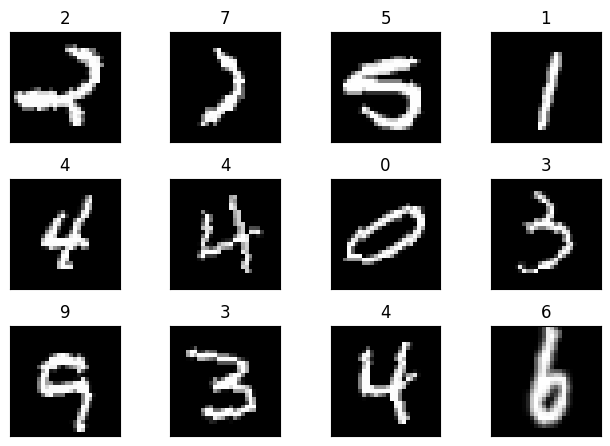

In [102]:
# Importing the function display_sample_images from utils.py to
# display random sample images in dataset.
from utils import display_sample_images

display_sample_images(train_loader)

CODE BLOCK: 7

In [95]:
# importing the model from the model.py
from model import Net


In [96]:
# Calling the model
model = Net().to(device)
# displaying the model summary.
summary(model,input_size = (1,28,28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


CODE BLOCK: 8

In [98]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [99]:
# Training the model of the train dataset.
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

# Testing the trained model on test dataset to the check loss and model accuracy
def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [103]:
# performance optimization of the model.
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 5

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=1.2156 Batch_id=117 Accuracy=28.98: 100%|██████████| 118/118 [00:20<00:00,  5.79it/s]


Test set: Average loss: 0.9326, Accuracy: 7704/10000 (77.04%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.3305 Batch_id=117 Accuracy=84.74: 100%|██████████| 118/118 [00:20<00:00,  5.74it/s]


Test set: Average loss: 0.1302, Accuracy: 9600/10000 (96.00%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.1079 Batch_id=117 Accuracy=95.41: 100%|██████████| 118/118 [00:21<00:00,  5.58it/s]


Test set: Average loss: 0.0845, Accuracy: 9714/10000 (97.14%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0697 Batch_id=117 Accuracy=96.66: 100%|██████████| 118/118 [00:21<00:00,  5.59it/s]


Test set: Average loss: 0.0577, Accuracy: 9814/10000 (98.14%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0755 Batch_id=117 Accuracy=97.29: 100%|██████████| 118/118 [00:20<00:00,  5.64it/s]


Test set: Average loss: 0.0459, Accuracy: 9860/10000 (98.60%)

Adjusting learning rate of group 0 to 1.0000e-02.


CODE BLOCK: 11

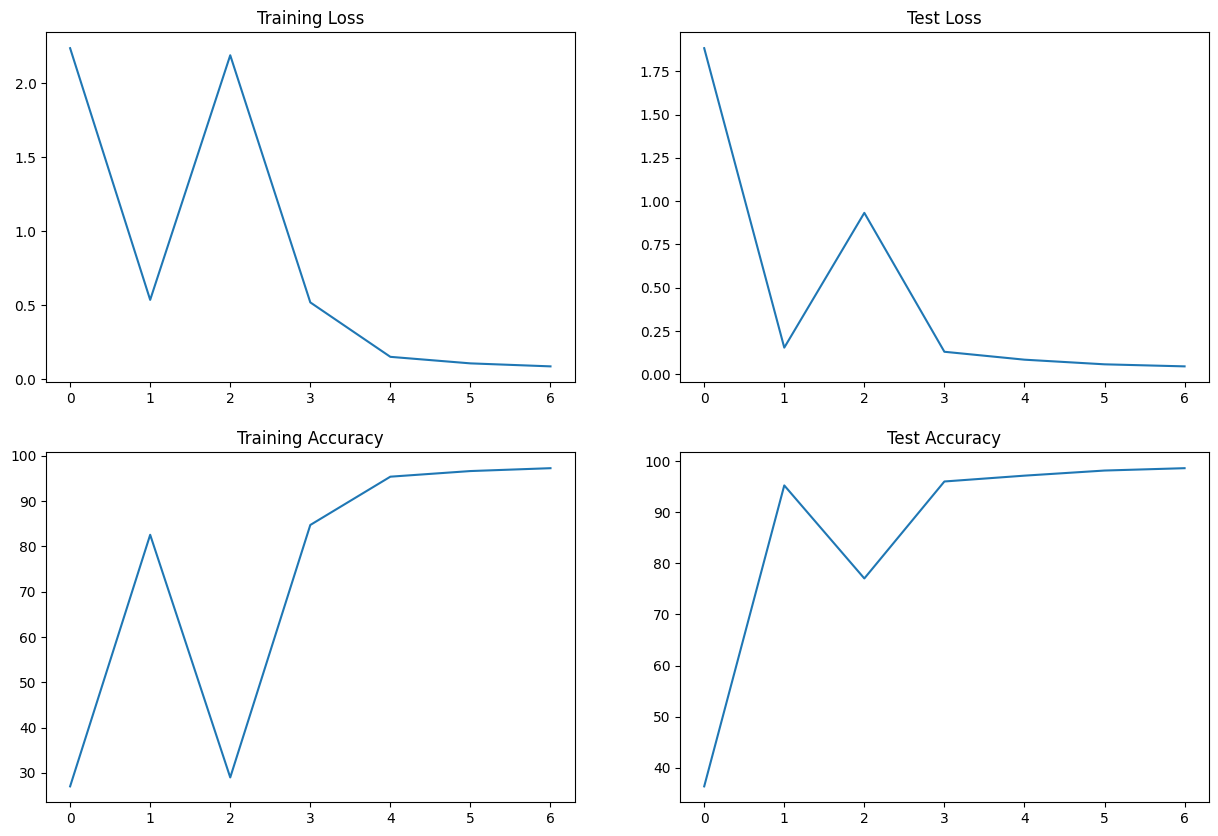

In [104]:
# import the display_accuracy from utils to display loss and accuracy graphically
from utils import display_accuracy

display_accuracy(train_losses,train_acc,test_losses,test_acc)